In [1]:
using Plots; gr(); 
using Statistics
using StatsBase
using DelimitedFiles
using StatsPlots

include("../src/crustDistribution.jl")

LoadError: ArgumentError: Package StatsPlots not found in current path:
- Run `import Pkg; Pkg.add("StatsPlots")` to install the StatsPlots package.


# Comparison of prior results

In [2]:
mutable struct Result
	name::String
	composition::Array{Float64, 1} # Lower, middle, upper
	layers::Array{Float64, 1} # Depth or layer index?
	#depth::Array{Float64, 1} # Depths for estimates 
	notes::String
end 


In [3]:
cm = readdlm("../data/christensen_mooney/christensen_mooney_sio2.csv", ',')

LoadError: ArgumentError: Cannot open '../data/christensen_mooney/christensen_mooney_sio2.csv': not a file

In [40]:
function Kohistan()
	deep = [(d > 52) & (d < 56) for d in crustDistribution.depth[:,4]] # appropriate crust depth
	_, upper, middle, lower = mean(crustDistribution.depth[deep,:], dims=1) # layer cutoffs for this depth 

	## Garnet granulite gabbro starting at 41 km depth (from figure 4) + sarangar gabbro above 
	lower_comp = ((lower-41)/(lower-middle)) * 48.59 + (middle-41)/(middle-lower) * 52.52  

	## Remainder of SPC, normalized by geobarametric depth, minus the bit of the sarangar gabbro included in the lower crust 
	middle_spc_comp = ((4.3- (middle-41))*52.52 + 3.0*51.09 + .8*57.95 + 2.3*50.83 + .4*72.01 + 1.1*49.61) / ((4.3- (middle-41)) + 3.0 + .8 + 2.3 + .4 + 1.1)
	pluton_comp = ((7/100)*53.64 + .67*64.49 + (9/100)*73.37 ) / (7/100 + .67 + (9/100))
	## SPC comp from 30 km (bottom of Gilgit complex, from table 1) to bottom of middle + pluton from upper boundary to 30km depth
	middle_comp = ((middle-30)*middle_spc_comp + (30-upper)*pluton_comp) / ((middle-30)+(30-upper))

	volcanics_comp = 56.83
	# 4km of volcanics (from table 1) + remainder pluton 
	upper_comp = (4*volcanics_comp + (upper-4)*pluton_comp)/upper
    
    return ([upper_comp, middle_comp, lower_comp], [upper/2, upper+(middle-upper)/2, middle+(lower-middle)/2])

end 

Kohistan (generic function with 1 method)

In [38]:
cdepth = mean(crustDistribution.depth[:,2:4], Weights(crustDistribution.weights), dims=1)
midpoints = [cdepth[1]/2, cdepth[1]+(cdepth[2]-cdepth[1])/2, cdepth[2]+(cdepth[3]-cdepth[2])/2]
println(reverse(midpoints))

cdepth = [0, cdepth[1], cdepth[1], cdepth[2], cdepth[2], cdepth[3]]
println(reverse(cdepth))

[32.32255339791592, 20.193064518935472, 6.909417469309636]
[38.07781269658017, 26.56729409925167, 26.56729409925167, 13.818834938619272, 13.818834938619272, 0.0]


In [42]:
k_comp, k_depth = Kohistan()

([63.028212047157815, 58.96918145313098, 49.27035262185525], [10.211622807017545, 29.38004385964912, 46.02859649122807])

In [44]:


results = [
	Result("Rudnick and Fountain", [52.3, 60.6, 66.0], [32.32255339791592, 20.193064518935472, 6.909417469309636], "upper crust from Taylor and McLennan 1985"),
	Result("Rudnick and Gao", [53.4, 63.5, 66.6], [32.32255339791592, 20.193064518935472, 6.909417469309636], ""),
	Result("Hacker et al. (most felsic)", [62, 68], [32.32255339791592, 20.193064518935472],
		"Most mafic felsic model of the three-layer models in this paper."),
	Result("Hacker et al. (most mafic)", [49, 53], [32.32255339791592, 20.193064518935472],
		"Most mafic model of the three-layer models in this paper."),
    Result("Christensen and Mooney", cm[:,1], cm[:,2], ""),
    Result("Benn and Keleman, minimum", [61.4, 57.5, 48.3, 46.2, 44.3, 43.0, 43.0, 42.3, 42.3],
        [10 ,15 ,20 ,25 ,30 ,35 ,40 ,45 ,50 ], ""),
    Result("Behn and Keleman, max", [79.6 ,78.3  ,73.8 ,68.1  ,65.9 ,63.7 ,63.0  ,62.1 ,61.9],
        [10 ,15 ,20 ,25 ,30 ,35 ,40 ,45 ,50 ], ""),
    Result("Kohistan", k_comp, k_depth, "")
];



In [50]:
p = plot(xlabel="% SiO2", yflip=true, size=(300,500), legend=:outerbottomright, legendtitlefontsize=9,
    fg_legend = :transparent, framestyle=:box)
for (r, result) in enumerate(results)
    plot!(result.composition, result.layers, label=result.name, markershape=:circle, markerstrokecolor=:auto)
end 

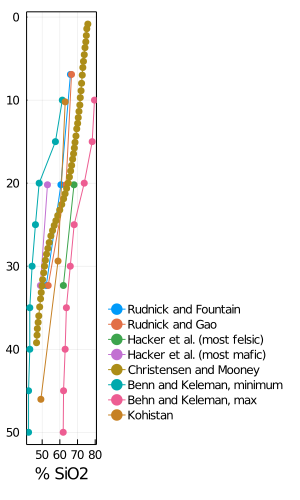

In [51]:
p

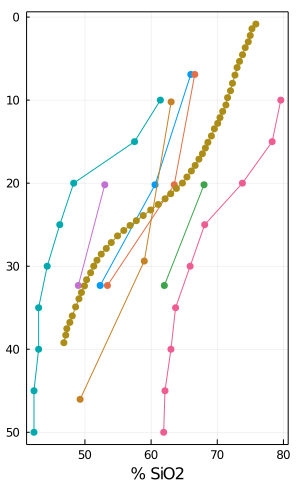

In [52]:
plot!(legend=false)

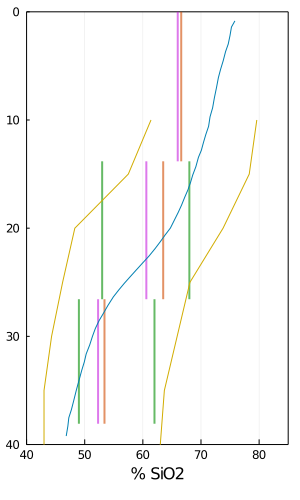

In [86]:
colors = distinguishable_colors(10, [RGB(1,1,1), RGB(0,0,0)], dropseed=true)

p2 = plot(xlabel="% SiO2", yflip=true, size=(300, 500), ygrid=false, fg_legend = :transparent, 
    legend=false, xlims=(40,85), framestyle=:box, ylims=(0,40))

# R & F 
plot!([52.3, 52.3], reverse(cdepth)[1:2], c=colors[1], label=false, linewidth=2, alpha=.6)
plot!([60.6, 60.6], reverse(cdepth)[3:4], c=colors[1], label=false, linewidth=2, alpha=.6)
plot!([66.0, 66.0], reverse(cdepth)[5:6], c=colors[1], linewidth=2, alpha=.6, label="Rudnick and Fountain")

#"Rudnick and Gao", [53.4, 63.5, 66.6]
plot!([53.4, 53.4], reverse(cdepth)[1:2], c=colors[2], label=false, linewidth=2, alpha=.6)
plot!([63.5, 63.5], reverse(cdepth)[3:4], c=colors[2], label=false, linewidth=2, alpha=.6)
plot!([66.6,66.6], reverse(cdepth)[5:6], c=colors[2], linewidth=2, alpha=.6, label="Rudnick and Gao")

# "Hacker et al. (most felsic)", [62, 68]
# "Hacker et al. (most mafic)", [49, 53
plot!([62, 62], reverse(cdepth)[1:2], c=colors[3], label=false, linewidth=2, alpha=.6)
plot!([68, 68], reverse(cdepth)[3:4], c=colors[3], label=false, linewidth=2, alpha=.6)
plot!([49, 49], reverse(cdepth)[1:2], c=colors[3], label=false, linewidth=2, alpha=.6)
plot!([53, 53], reverse(cdepth)[3:4], c=colors[3], label="Hacker et al", linewidth=2, alpha=.6)

plot!(results[5].composition, results[5].layers, label=results[5].name, c=colors[4])

plot!(results[6].composition, results[6].layers, label="Behn and Keleman", c=colors[5])
plot!(results[7].composition, results[7].layers, label=false, c=colors[5])

#plot!(results[8].composition, results[8].layers, label=results[8].name, c=colors[6])

#savefig("viz/prior_work_compare.pdf")

# Elevation of the continents

In [90]:
jps_ele = readdlm("../data/G3Dv3/LLNL_G3Dv3.Tessellated.Layer03_Sediment_1_top.txt")[:,1]
jps_sealevel = readdlm("../data/G3Dv3/LLNL_G3Dv3.Tessellated.Coordinates.txt")[:,4];

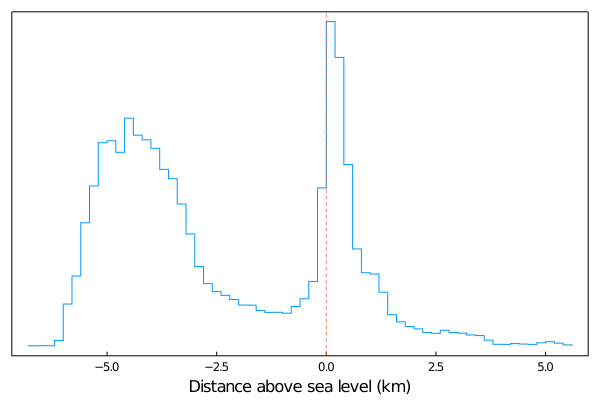

In [108]:
stephist(jps_ele .- jps_sealevel, normalize=:pdf, legend=false, bins=100,
    grid=false, xlabel="Distance above sea level (km)", yticks=false, framestyle=:box)
vline!([0.0], linestyle=:dash, alpha=.8)
#savefig("viz/continent_histogram.png")

In [111]:
using Distributions


In [199]:
# error distribution 
		dat, header = readdlm("../data/adjustedPerplexRes.csv", ',', header=true);
		header = header[:]
		# Interested in non-nan differences between actual and Perplex data 
		ers = fill(NaN, (size(dat)[1],3));
		ers[:,2] .= dat[:,findfirst(isequal("perplex vp"), header)] .- dat[:,findfirst(isequal("dabie vp"), header)]
		ers[:,3] .= dat[:,findfirst(isequal("perplex vp/vs"), header)] .- dat[:,findfirst(isequal("dabie vp/vs"), header)]
		ers[:,1] .= dat[:,findfirst(isequal("perplex rho"), header)] .- (1000 .* dat[:,findfirst(isequal("dabie rho"), header)]);
		ers = ers[.!(isnan.(sum(ers, dims=2)))[:],:]; 
		N_er = fit(MvNormal, ers')

FullNormal(
dim: 3
μ: [8.107486639757822, 0.1826038390510999, -0.005874874901643257]
Σ: [21700.876186806006 38.63749046310393 -2.3238833172909272; 38.63749046310393 0.15924178111736856 -0.0031173371421553786; -2.3238833172909272 -0.0031173371421553786 0.002488743706415703]
)


In [200]:
zero_mean = MvNormal(zeros(3), N_er.Σ)

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [21700.876186806006 38.63749046310393 -2.3238833172909272; 38.63749046310393 0.15924178111736856 -0.0031173371421553786; -2.3238833172909272 -0.0031173371421553786 0.002488743706415703]
)


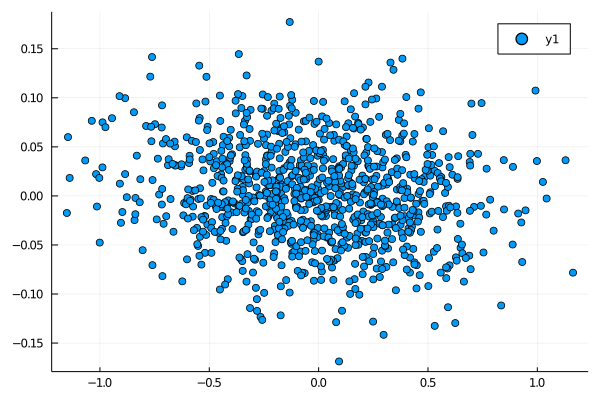

In [173]:
nums = rand(zero_mean, 1000)
scatter(nums[1,:], nums[2,:])

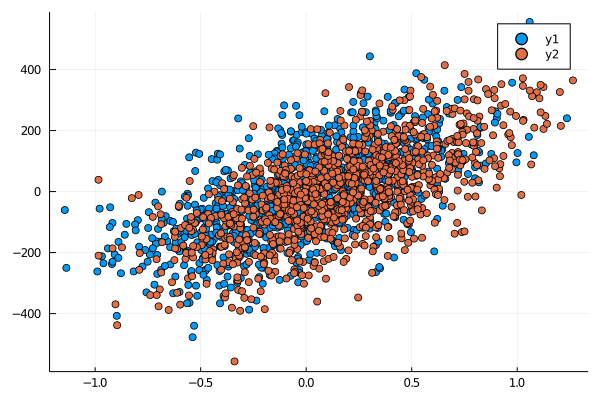

In [143]:
nums=rand(N_er, 1000)
scatter!(nums[1,:], nums[3,:])

In [146]:
typeof(N_er) <: Distribution

true

In [180]:
include("../src/invertData.jl")
include("../src/config.jl")

284.20000000000005

In [176]:
nOriginal()

22530

In [214]:
upperDat, (upperCrustbase, upperAge, upperLat, upperLong) = getAllSeismic(
        6, n=nOriginal(), ageModel=EarthChemAge(10, 3), latlong=true, 
        dataSrc="Crust1.0", dataUncertainty=.1);

Using EarthChem age model
Using 9646 TC1 values for ages


In [191]:
upperDatOrig, (base, age, lat, long) = getAllSeismic(6, resample=false);